In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.descriptivestats import describe
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy as scipy
import arch

import fredapi as fa
from local_settings import fred as settings
fred = fa.Fred(settings['api_key'])

In [2]:
tickers = []

with open('tickers.txt') as f:
    for line in f:
        tickers.append(line.strip())

In [3]:
assets = {}

for ticker in tickers:
    assets[ticker] = fred.get_series(ticker).loc['2020-06-01':'2023-10-01']

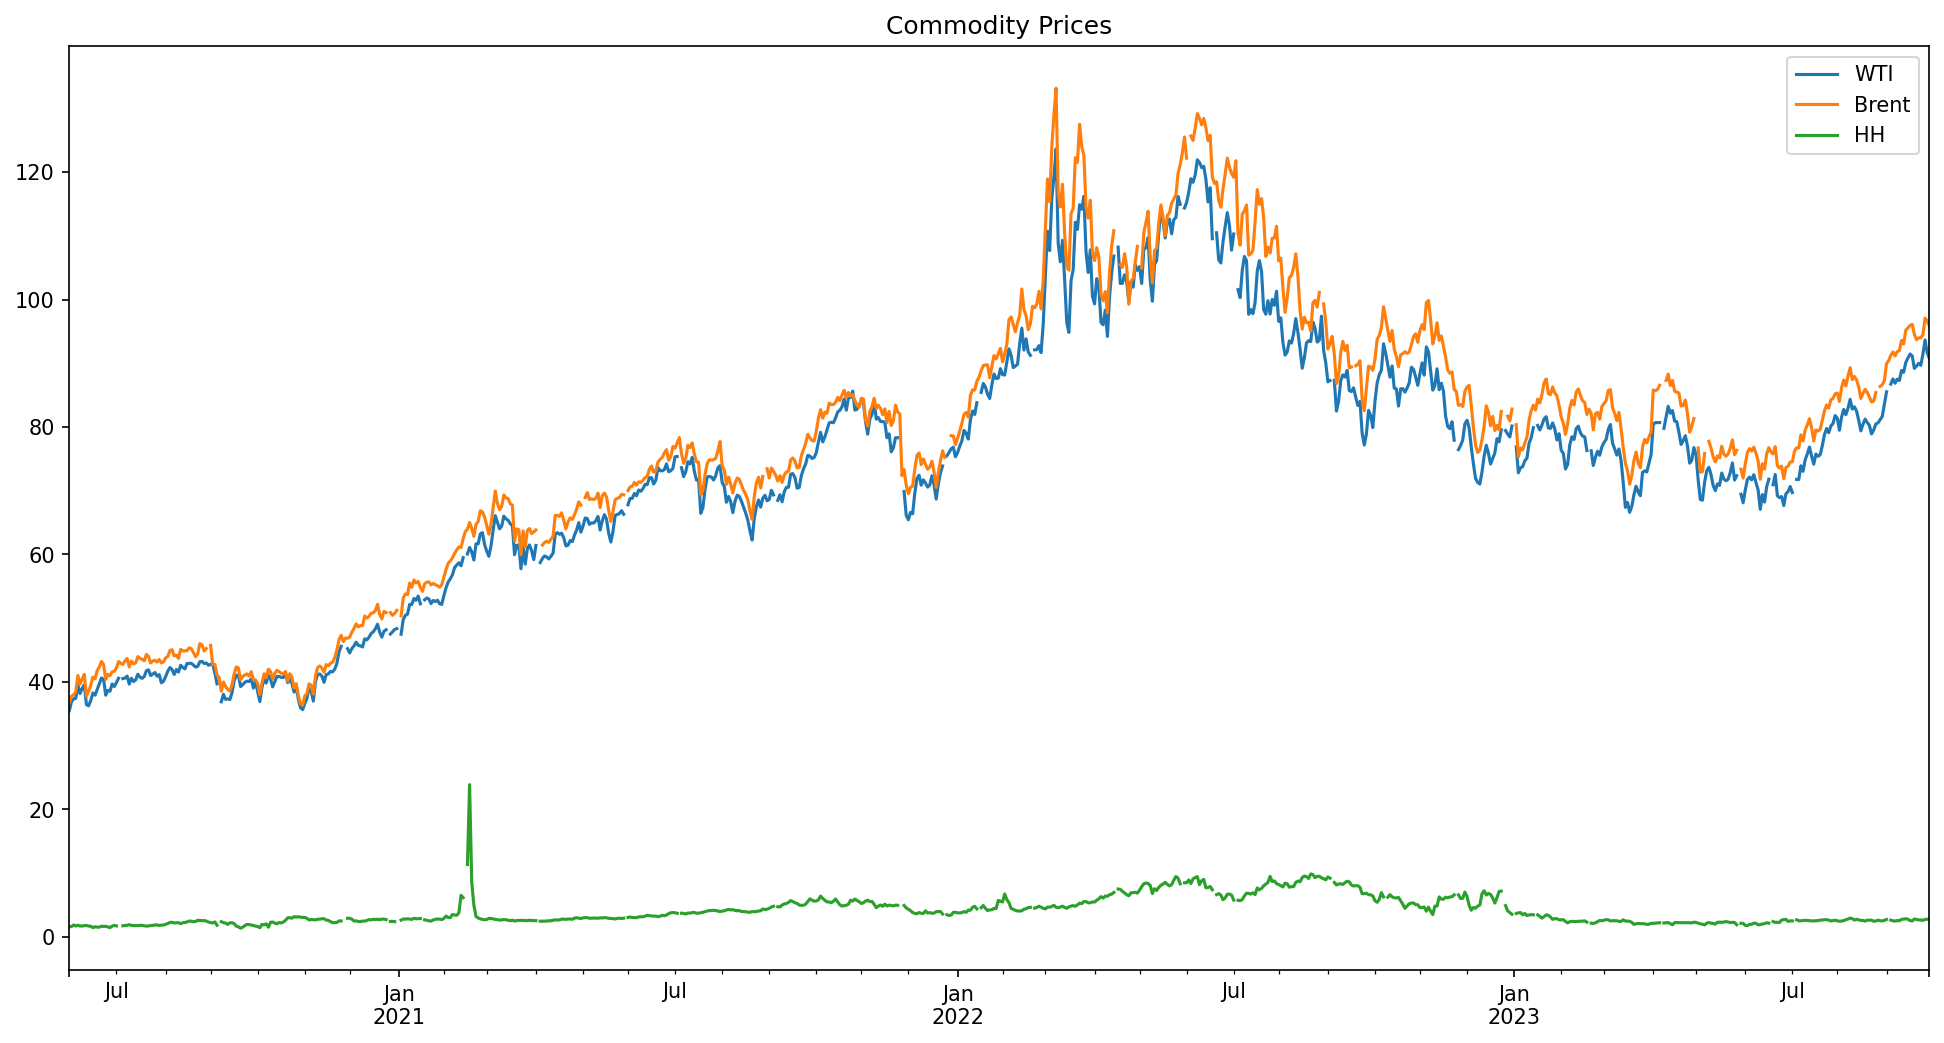

In [4]:
plt.figure(figsize=(16, 8), dpi=150) 

assets['DCOILWTICO'].plot(label='WTI')
assets['DCOILBRENTEU'].plot(label='Brent')
assets['DHHNGSP'].plot(label='HH')
#assets['PNGASEUUSDM'].plot(label='TTF')

plt.title('Commodity Prices')
plt.legend()

In [5]:
returns = pd.DataFrame.from_dict(assets).fillna(method='ffill')

for ticker in tickers:
    returns['Ret_' + ticker] = np.log(returns[ticker]) - np.log(returns[ticker].shift(1))

returns = returns.dropna() # only nulls left are the starting returns; will also have an issue with negative prices when series extended back far enough

returns.head()

,DCOILWTICO,DCOILBRENTEU,DHHNGSP,Ret_DCOILWTICO,Ret_DCOILBRENTEU,Ret_DHHNGSP
2020-06-02,36.88,37.72,1.58,0.038418,0.026324,-0.006309
2020-06-03,37.33,37.98,1.84,0.012128,0.006869,0.152341
2020-06-04,37.42,38.41,1.68,0.002408,0.011258,-0.090972
2020-06-05,39.49,41.00,1.80,0.053842,0.065254,0.068993
2020-06-08,38.17,39.66,1.68,-0.033998,-0.033229,-0.068993


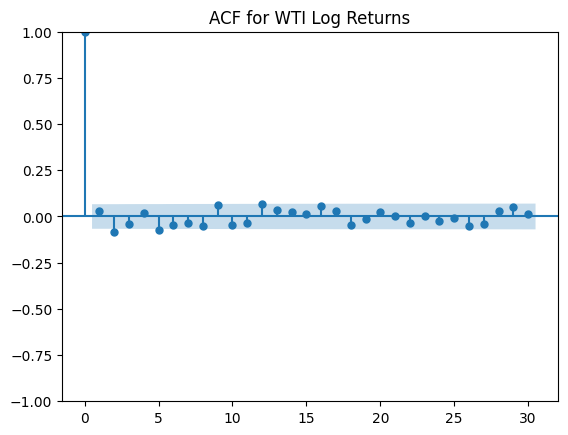

In [6]:
series_wti = returns['Ret_DCOILWTICO']

acf_ret_wti = acf(series_wti)
plot_acf(series_wti, lags=30, title='ACF for WTI Log Returns')
plt.show()

ACF of log returns indicates some AR/MA property among returns with lags 2, 5, 9, 12 being statistically significant

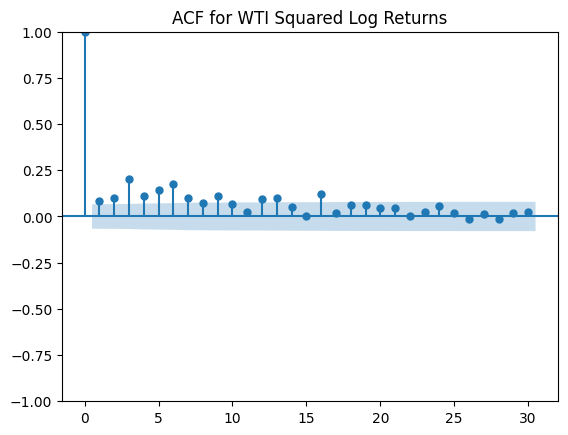

In [7]:
acf_retsq_wti = acf(series_wti**2)
plot_acf(series_wti**2, lags=30, title='ACF for WTI Squared Log Returns')
plt.show()

ACF of squared log returns indicates some AR property among squared returns for (G)ARCH with lags up to 9 and several others being statistically significant

In [8]:
describe(series_wti)

,Ret_DCOILWTICO
nobs,8.690000e+02
missing,0.000000e+00
mean,1.080642e-03
std_err,8.235387e-04
upper_ci,2.694748e-03
lower_ci,-5.334643e-04
std,2.427694e-02
iqr,2.791480e-02
iqr_normal,2.069327e-02
mad,1.793358e-02


negative skewness

high kurtosis

jarque_bera_pval close to zero --> H0 normality rejected

In [9]:
mu, sigma = np.mean(series_wti), np.std(series_wti)
x = np.random.normal(mu, sigma, 1000)
x = pd.Series(x, name='Normal Distribution')

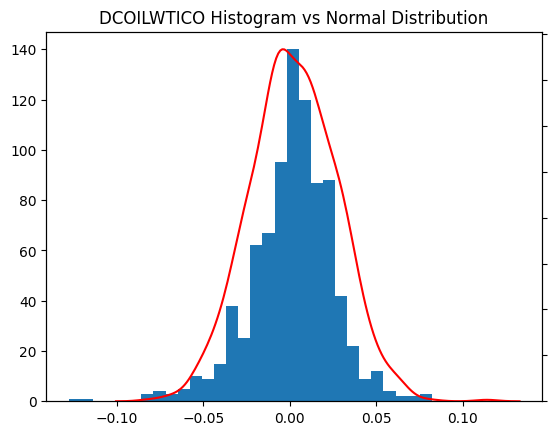

In [10]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.grid(False)
ax1.hist(series_wti, bins=30)
g1 = sns.kdeplot(x, ax=ax2, color='r')
g1.set(ylabel=None)
g1.set(yticklabels=[])
plt.title('DCOILWTICO Histogram vs Normal Distribution');

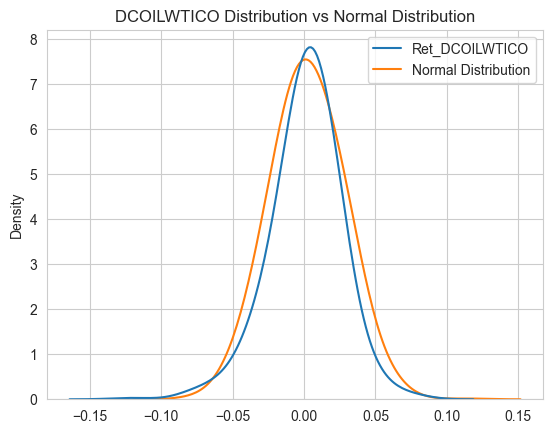

In [11]:
sns.set_style('whitegrid')
series_wti_norm = pd.concat([series_wti, x], axis=1)
sns.kdeplot(data=series_wti_norm, bw_method=0.5)
plt.title('DCOILWTICO Distribution vs Normal Distribution');

Leptokurtic distribution

Negative skew

Fat tails, particularly for negative returns

In [12]:
arch_test = het_arch(series_wti)
arch_test

(74.01086220849128,
 7.409383379921156e-12,
 7.995169376403505,
 2.158539007848078e-12)

In [13]:
arch_test = het_arch(series_wti, nlags=5)
arch_test

(58.30251863526131,
 2.7243829457468232e-11,
 12.417454974371093,
 1.1881259650242177e-11)

H0 no arch effects rejected (p-value close to zero)

In [14]:
proportion_in_train = 0.9
split = int(proportion_in_train*len(series_wti))

series_wti_train = series_wti.iloc[:split]
series_wti_test = series_wti.iloc[split+1:]

In [15]:
garch11 = arch.arch_model(series_wti_train, mean='Constant', vol='GARCH', p=1, q=1)
res_garch11 = garch11.fit()
res_garch11.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 42501858.72012455
Iteration:      2,   Func. Count:     17,   Neg. LLF: 4227906.878741824
Iteration:      3,   Func. Count:     28,   Neg. LLF: 60099033.43577653
Iteration:      4,   Func. Count:     39,   Neg. LLF: 67020144880.28921
Iteration:      5,   Func. Count:     48,   Neg. LLF: 76344.51173275821
Iteration:      6,   Func. Count:     59,   Neg. LLF: 2531.777714687399
Iteration:      7,   Func. Count:     69,   Neg. LLF: -1810.9613225437502
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1810.9613229324277
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 7


C:\Users\afost\Documents\UW\Y2\S1\Thesis\cmd_forecast\Model\venv\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         Ret_DCOILWTICO   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1810.96
Distribution:                  Normal   AIC:                          -3613.92
Method:            Maximum Likelihood   BIC:                          -3595.28
                                        No. Observations:                  782
Date:                Wed, Nov 15 2023   Df Residuals:                      781
Time:                        19:55:00   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1322e-03  7.912e-04      1.431      0.152 [-4.185e-04,2.683e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.2272e-05  1.356e-05      4.591  4.410e-06 [3.569e-05,8.886e-05]
alpha[1]       0.1000  2.638e-02      3.790  1.505e-04   [4.829e-02,  0.152]
beta[1]        0.7999  2.700e-02     29.622 7.744e-193     [  0.747,  0.853]
============================================================================

Covariance estimator: robust
"""

In [16]:
garch11 = arch.arch_model(series_wti_train, mean='Zero', vol='GARCH', p=1, q=1)
res_garch11 = garch11.fit()
res_garch11.summary()

Iteration:      1,   Func. Count:      4,   Neg. LLF: -1809.999300967107
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1809.999301378689
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


C:\Users\afost\Documents\UW\Y2\S1\Thesis\cmd_forecast\Model\venv\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:         Ret_DCOILWTICO   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                1810.00
Distribution:                  Normal   AIC:                          -3614.00
Method:            Maximum Likelihood   BIC:                          -3600.01
                                        No. Observations:                  782
Date:                Wed, Nov 15 2023   Df Residuals:                      782
Time:                        19:55:00   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.2330e-05  1.267e-05      4.918  8.741e-07 [3.749e-05,8.717e-05]
alpha[1]       0.1000  2.641e-02      3.786  1.531e-04   [4.823e-02,  0.152]
beta[1]        0.8000  2.713e-02     29.485 4.478e-191     [  0.747,  0.853]
============================================================================

Covariance estimator: robust
"""

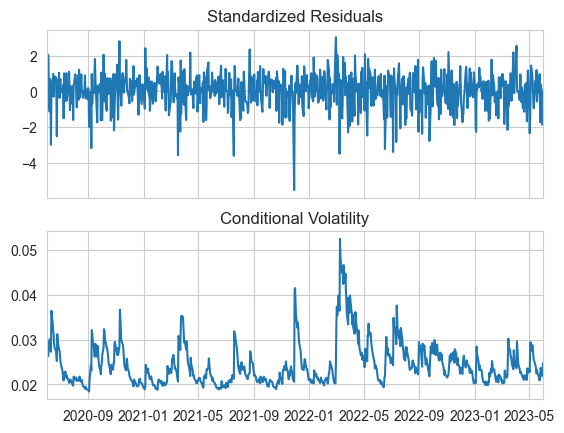

In [17]:
fig = res_garch11.plot()

In [18]:
acorr_ljungbox(res_garch11.std_resid**2, [10, 15, 20])

,lb_stat,lb_pvalue
10,5.827400,0.829550
15,10.114137,0.812500
20,12.494963,0.897987


In [19]:
res_garch11.aic

-3613.998602757378

In [20]:
res_garch11.bic

-3600.0130385357425

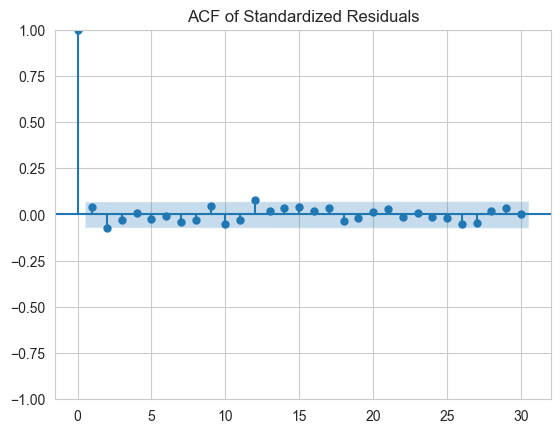

In [21]:
plot_acf(res_garch11.std_resid, lags=30, title='ACF of Standardized Residuals')
plt.show()

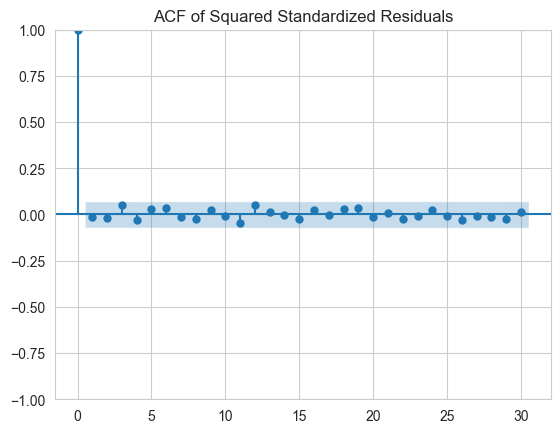

In [22]:
plot_acf(res_garch11.std_resid**2, lags=30, title='ACF of Squared Standardized Residuals')
plt.show()

All coefficients are statistically significant at 5% confidence level after removing the insignificant mean equation constant

Ljung-Box test on squared standardised residuals: H0 no autocorrelation not rejected at 5% at all 10, 15 & 20 lags

ACF of squared standardised residuals suggests the conditional variance equation is complete - although will see what GARCH(2,1) & GARCH(1,2) produce

ACF of standardised residuals suggets the mean equation can be modified - to be done later

In [62]:
for_garch11 = res_garch11.forecast(horizon=20, start='2023-05-01')

<Axes: >

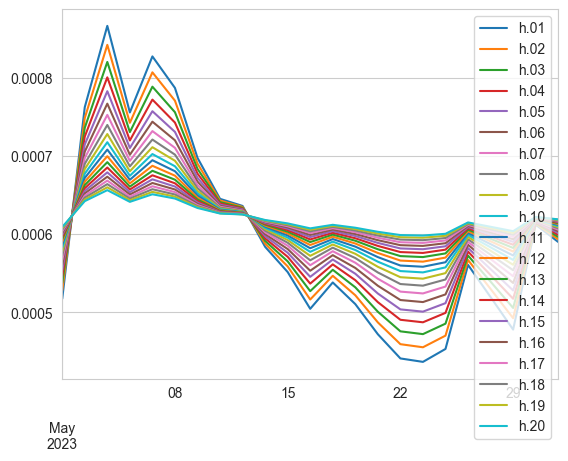

In [64]:
for_garch11.variance['2023-05-01':].plot()

In [63]:
print(for_garch11.variance.tail())

                h.01      h.02      h.03      h.04      h.05      h.06   
2023-05-25  0.000561  0.000567  0.000572  0.000578  0.000582  0.000586  \
2023-05-26  0.000519  0.000530  0.000539  0.000548  0.000555  0.000562   
2023-05-29  0.000478  0.000492  0.000505  0.000517  0.000528  0.000537   
2023-05-30  0.000612  0.000613  0.000614  0.000615  0.000616  0.000617   
2023-05-31  0.000590  0.000593  0.000596  0.000599  0.000601  0.000604   

                h.07      h.08      h.09      h.10      h.11      h.12   
2023-05-25  0.000590  0.000593  0.000596  0.000599  0.000601  0.000604  \
2023-05-26  0.000568  0.000574  0.000579  0.000583  0.000587  0.000591   
2023-05-29  0.000546  0.000554  0.000561  0.000567  0.000573  0.000578   
2023-05-30  0.000617  0.000618  0.000618  0.000619  0.000619  0.000620   
2023-05-31  0.000606  0.000607  0.000609  0.000610  0.000612  0.000613   

                h.13      h.14      h.15      h.16      h.17      h.18   
2023-05-25  0.000606  0.000607  0.00

In [38]:
series_wti_train.tail()

2023-05-25   -0.036841
2023-05-26    0.009304
2023-05-29    0.000000
2023-05-30   -0.040908
2023-05-31   -0.019483
Name: Ret_DCOILWTICO, dtype: float64

In [39]:
series_wti_test.head()

2023-06-02    0.023547
2023-06-05    0.005281
2023-06-06   -0.005978
2023-06-07    0.011232
2023-06-08   -0.017247
Name: Ret_DCOILWTICO, dtype: float64